<a href="https://colab.research.google.com/github/Wetiqe/NMA-Project/blob/main/Kay_Alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [108]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [109]:
USE_GPU = True
fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_labels_val.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/yqb3e/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

In [110]:
with np.load(fname) as dobj:
    dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')


`labels` is a 4 by stim array of class names:  
- row 3 has the labels predicted by a deep neural network (DNN) trained on Imagenet
- rows 0-2 correspond to different levels of the wordnet hierarchy for the DNN predictions

In [111]:
print(labels.shape)
# print(np.bincount(labels[0]))
sum = 0
for iter in labels[0]:
    if iter == 'artifact':
        sum += 1
print(sum)

(4, 1750)
812


In [112]:
print(dat.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


`dat` has the following fields:  
- `stimuli`: stim x i x j array of grayscale stimulus images
- `stimuli_test`: stim x i x j array of grayscale stimulus images in the test set  
- `responses`: stim x voxel array of z-scored BOLD response amplitude
- `responses_test`:  stim x voxel array of z-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

In [113]:
print(dat["stimuli"].shape)

(1750, 128, 128)


In [114]:
print(dat["responses"].shape)
print(dat["responses"][0])

(1750, 8428)
[ 0.53109303 -0.1711666  -2.18185285 ... -0.08087291 -0.07181383
 -1.14688391]


This is the number of voxels in each ROI. Note that `"Other"` voxels have been removed from this version of the dataset:

In [115]:
print(dict(zip(dat["roi_names"], np.bincount(dat["roi"]))))
print(dat['roi'], dat['roi_names'])

{'Other': 0, 'V1': 1294, 'V2': 2083, 'V3': 1790, 'V3A': 484, 'V3B': 314, 'V4': 1535, 'LatOcc': 928}
[3 3 3 ... 3 3 6] ['Other' 'V1' 'V2' 'V3' 'V3A' 'V3B' 'V4' 'LatOcc']


Each stimulus is a 128 x 128 grayscale array:

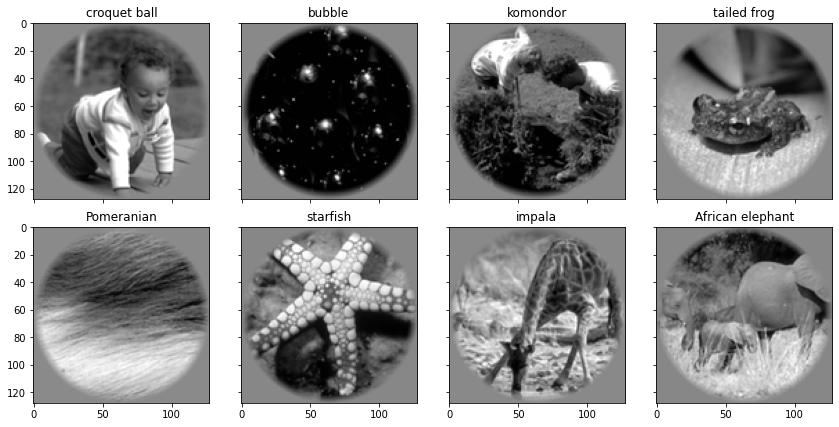

In [116]:
f, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli"], labels[-1,:]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
f.tight_layout()

Each stimulus is associated with a pattern of BOLD response across voxels in visual cortex:

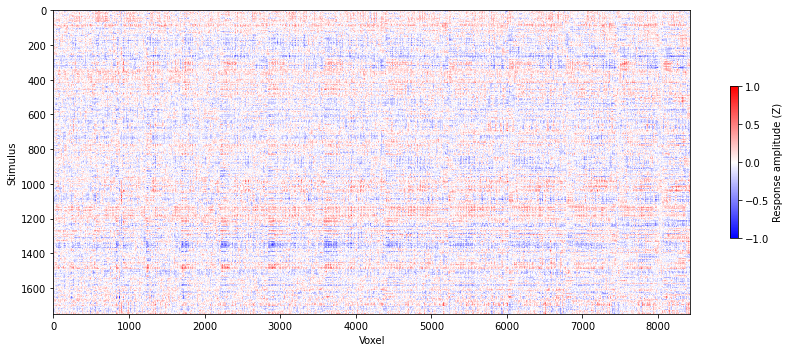

In [117]:
f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(dat["responses"], aspect="auto", vmin=-1, vmax=1, cmap="bwr")
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

The training/validation splits from the original paper are retained, so the 120 test stimuli and responses are in separate data structures:

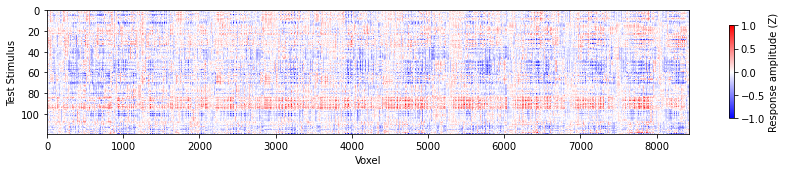

In [118]:
f, ax = plt.subplots(figsize=(12, 2.5))
ax.set(xlabel="Voxel", ylabel="Test Stimulus")
heatmap = ax.imshow(dat["responses_test"], aspect="auto", vmin=-1, vmax=1, cmap="bwr")
f.colorbar(heatmap, shrink=.75, label="Response amplitude (Z)")
f.tight_layout()

----------------
# Set up

In [119]:
#@title import library
import random
import pandas as pd
import numpy as np
import copy

from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm.auto import tqdm

from torchvision import transforms
import torchvision.models as models

In [120]:
#@title Set random seed and device
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [121]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu


------
# Data Preprocessing





## Label Encoding
Make dictionary from labels to numbers.

In [122]:
from sklearn import preprocessing

# prepare certain level of labels
label_level = 1
ori_labels_train = labels[label_level - 1, :]
ori_labels_test = val_labels[label_level - 1, :]
ori_labels_all = np.append(ori_labels_train, ori_labels_test)
# label encoding
le = preprocessing.LabelEncoder()
labels_all = le.fit_transform(ori_labels_all)
targets_train = labels_all[ : len(ori_labels_train)]
targets_test = labels_all[len(ori_labels_train) : ]
targets_test

array([1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 5, 5, 1, 5, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 5, 1, 1, 0, 0, 5, 0, 1, 1, 0, 5, 1, 1, 3, 0, 2, 1, 2, 5, 5, 2,
       0, 0, 2, 1, 5, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 5, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 4, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [123]:
for t in range(5):
    total = 0
    for i in targets_train:
        if i == t:
            total +=1
    print(total / len(targets_train))

0.3365714285714286
0.464
0.04114285714285714
0.044
0.002857142857142857


In [124]:
num_of_classes = len(np.unique(labels_all))
print(f"Total number of classes:{num_of_classes}")

Total number of classes:8


## Prepare the stimulus

In [125]:
stimuli_tr = dat["stimuli"]
stimuli_ts = dat["stimuli_test"]
stimuli_tr.shape

(1750, 128, 128)

想用dataloader的 transform参数进行data augumentation 就必须要变成三维图像，否则会出现维度不匹配的bug。因为增加channel数目后并没有实际上增加任何信息，所以并不会影响结果。

In [126]:
#@title 
# prepare the input and target for alexnet
# Converting stimulus to RGB and changing the scale to 0-255 (Specific to Kay dataset images)
stimuli_tr = dat["stimuli"]
stimuli_ts = dat["stimuli_test"]
stimuli_tr_xformed = np.zeros((1750, 3, 128, 128))
stimuli_ts_xformed = np.zeros((120, 3, 128, 128))
for i in range(1750): 
  img = stimuli_tr[i, :, :]
  img = ((img - np.min(img))*255/(np.max(img) - np.min(img))).astype(int)
  stimuli_tr_xformed[i, :, :, :] = [img,img,img]

for i in range(120):
  img = stimuli_ts[i, :, :]
  img = ((img - np.min(img))*255/(np.max(img) - np.min(img))).astype(int)
  stimuli_ts_xformed[i, :, :, :] = [img, img, img]



In [127]:
# @title Custom dataloader for loading images in numpy array

class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None):
    self.data = data
    self.targets = torch.LongTensor(targets)
    self.transform = transform

  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]

    if self.transform:
        x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1, 2, 0))
        x = self.transform(x)

    return x, y

  def __len__(self):
      return len(self.data)


transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
                                 ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()]),
             }

batch_size = 30
test_loader = DataLoader(MyDataset(list(stimuli_ts_xformed),
            targets_test, transform=transform['test']),batch_size=batch_size)
train_loader = DataLoader(MyDataset(list(stimuli_tr_xformed),
            targets_train, transform=transform['train']),
        batch_size=batch_size)



In [128]:
# @title Custom dataloader for loading images in numpy array

class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None):
    self.data = data
    self.targets = torch.LongTensor(targets)
    self.transform = transform

  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]

    if self.transform:
        x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1, 2, 0))
        x = self.transform(x)

    return x, y

  def __len__(self):
      return len(self.data)


transform = {
    'train': transforms.Compose([
        transforms.ToTensor()
                                 ]),
    'test': transforms.Compose([
        transforms.ToTensor()]),
             }

batch_size = 30
test_loader = DataLoader(MyDataset(list(stimuli_ts_xformed),
            targets_test, transform=transform['test']))
train_loader = DataLoader(MyDataset(list(stimuli_tr_xformed),
            targets_train, transform=transform['train']),
        batch_size=batch_size)


------
# Finetune Alexnet

## Define Train Test Function

In [129]:
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False, device='cpu'):
  """
  Accumulate training loss/Evaluate performance

  Args:
    net: instance of Net class
      Describes the model with ReLU activation, batch size 128
    criterion: torch.nn type
      Criterion combines LogSoftmax and NLLLoss in one single class.
    optimizer: torch.optim type
      Implements Adam algorithm.
    train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
    num_epochs: int
      Number of epochs [default: 1]
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    Nothing
  """
  net.train()
  training_losses = []
  for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Zero the parameter gradients
      optimizer.zero_grad()

      # forward 
      outputs = net(inputs)
        # backward
      _, predicted = torch.max(outputs, 1)
      loss = criterion(predicted.float(), labels.float())
      loss.requires_grad = True
      loss.backward()

        # optimize
      optimizer.step()
      
      # Print statistics
      running_loss += loss.item()
    if verbose:
        training_losses.append(running_loss)

  net.eval()

  def test(data_loader):
    """
    Function to gauge network performance

    Args:
      data_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.

    Returns:
      acc: float
        Performance of the network
      total: int
        Number of datapoints in the dataloader
    """
    correct = 0
    total = 0
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).float()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print(f"Accuracy on the {train_total} training samples: {train_acc:0.2f}")
    print(f"Accuracy on the {test_total} testing samples: {test_acc:0.2f}")

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('epoch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc

## Train the Alexnet

In [130]:
net = models.alexnet(pretrained=True)
num_ftrs = net.classifier[6].in_features
net.classifier[6] = nn.Linear(num_ftrs, num_of_classes)
net.to(DEVICE)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on the 1750 training samples: 21.43
Accuracy on the 120 testing samples: 22.50


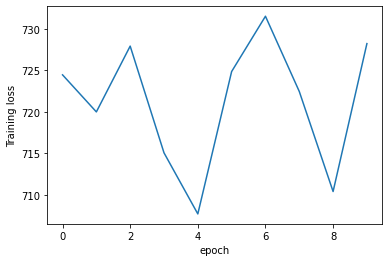

In [131]:
criterion = nn.MSELoss()
learning_rate = 0.1  # Change this
num_epochs = 10  # Change this
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

_, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=DEVICE)


In [132]:
# Training
criterion = nn.MSELoss()
learning_rate = 1e-6  # Change this
num_epochs =  5  # Change this
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)


best_model_wts = copy.deepcopy(net.state_dict())
best_loss = 10.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs - 1}")
    print('-' * 20)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            net.train()  # Set model to training mode
            dataloader=train_loader
            size=1750
        else:
            net.eval()   # Set model to evaluate mode
            dataloader=test_loader
            size=120
        running_loss = 0.0
        running_corrects = 0
        correct = 0
        total = 0
        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                _, predicted = torch.max(outputs, 1)
                loss = criterion(predicted.float(), labels.float())
                loss.requires_grad = True
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            epoch_loss = running_loss / size
        print(f"{phase} Loss: {epoch_loss:.4f}")
        acc = 100 * correct / total
        print(f"Accuracy on the {total} training samples: {acc:0.2f}")
        print(f"Accuracy on the {total} testing samples: {acc:0.2f}")

                
        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(net.state_dict())


# load best model weights
net.load_state_dict(best_model_wts)

Epoch 0/4
--------------------
train Loss: 12.3154
Accuracy on the 1750 training samples: 21.43
Accuracy on the 1750 testing samples: 21.43
val Loss: 13.7750
Accuracy on the 120 training samples: 22.50
Accuracy on the 120 testing samples: 22.50
Epoch 1/4
--------------------
train Loss: 12.4194
Accuracy on the 1750 training samples: 22.57
Accuracy on the 1750 testing samples: 22.57
val Loss: 13.7750
Accuracy on the 120 training samples: 22.50
Accuracy on the 120 testing samples: 22.50
Epoch 2/4
--------------------
train Loss: 12.0886
Accuracy on the 1750 training samples: 23.09
Accuracy on the 1750 testing samples: 23.09
val Loss: 13.7750
Accuracy on the 120 training samples: 22.50
Accuracy on the 120 testing samples: 22.50
Epoch 3/4
--------------------
train Loss: 12.2634
Accuracy on the 1750 training samples: 21.83
Accuracy on the 1750 testing samples: 21.83
val Loss: 13.7750
Accuracy on the 120 training samples: 22.50
Accuracy on the 120 testing samples: 22.50
Epoch 4/4
----------

<All keys matched successfully>

## Get the weights of the last layer

In [133]:
!pip install torch_intermediate_layer_getter --quiet
from torch_intermediate_layer_getter import IntermediateLayerGetter as MidGetter
from scipy.spatial.distance import pdist
from scipy.stats import pearsonr

In [134]:
## Extract features of all the intermediate layers from ImageNet-trained and finetuned Alexnet
return_layers = {
    'features.2': 'conv1',
    'features.5': 'conv2',
    'features.7': 'conv3',
    'features.9': 'conv4',
    'features.12': 'conv5',
    'classifier.1': 'fc1',
    'classifier.4': 'fc2',
    'classifier.6': 'fc3',
    }

# Loading AlexNet pretrained on Imagenet
net_im = models.alexnet(pretrained=True)
net_im.eval()
net_im.to(DEVICE)


# Setting up feature extraction step
midfeat_ft = MidGetter(net, return_layers=return_layers, keep_output=True)
midfeat_im = MidGetter(net_im, return_layers=return_layers, keep_output=True)

# Loading validation data and forward pass through the network

loader = DataLoader(MyDataset(list(stimuli_ts_xformed), targets_test), batch_size=120)
for inputs, labels in loader:
    inputs = inputs.to(DEVICE).float()
    mid_outputs_ft, _ = midfeat_ft(inputs)
    mid_outputs_im, _ = midfeat_im(inputs)

# RSA
Compare the similarity between BOLD signal and layers of fituned/pretrained Alexnet

## Using Raw BOLD  

In [160]:
# Loading V1 and LOC responses
ids = [np.where(dat['roi'] == i) for i in np.unique(dat['roi'])]
Bolds = [np.squeeze(dat['responses_test'][:, id]) for id in ids]

# Observed dissimilarity  - Correlation
fMRI_dist_metric_ft = "euclidean"  # ['correlation', 'euclidean']
fMRI_dist_metric_im = "correlation"  # ['correlation', 'euclidean']

Alexnet_ft_dist_metric = "euclidean"  # ['correlation', 'euclidean']
Alexnet_im_dist_metric = "correlation"  # ['correlation', 'euclidean']

pdist_fts = [pdist(bold, fMRI_dist_metric_ft) for bold in Bolds]
pdist_ims = [pdist(bold, fMRI_dist_metric_im) for bold in Bolds]


# Comparing representation of V1 and LOC across different layers of Alexnet
layer_num = int(len(return_layers)); roi_num = int(len(ids))
r = np.zeros((roi_num*2, layer_num)) # 14 x 8 matrix
p = r.copy()
for i,l in enumerate(mid_outputs_ft.keys()):
    for j in range(roi_num):
        dnet_ft = pdist(torch.flatten(mid_outputs_ft[l], 1, -1).cpu().detach().numpy(),
                        Alexnet_ft_dist_metric)
        dnet_im = pdist(torch.flatten(mid_outputs_im[l], 1, -1).cpu().detach().numpy(),
                        Alexnet_im_dist_metric)
        r[j*2, i], p[j*2, i] = pearsonr(dnet_ft, pdist_fts[j])
        r[j*2+1, i], p[j*2+1, i] = pearsonr(dnet_im, pdist_ims[j])

### Plotting correlation between observed and predicted dissimilarity values


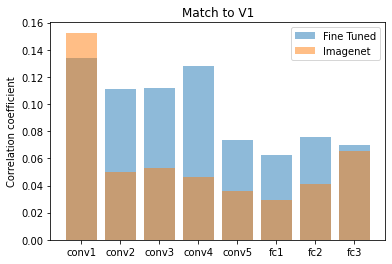

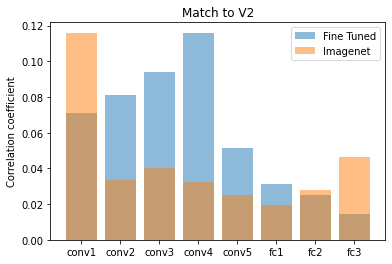

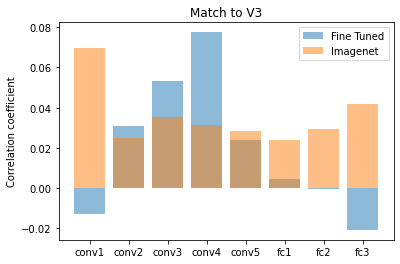

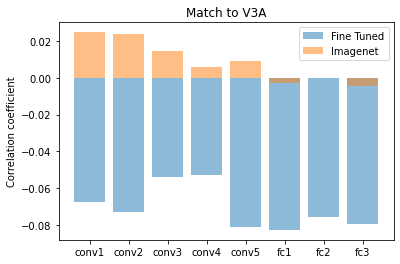

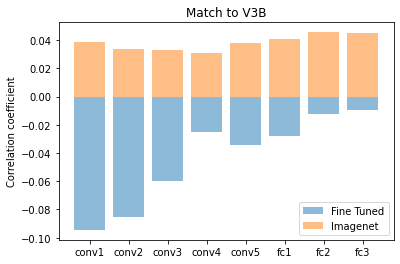

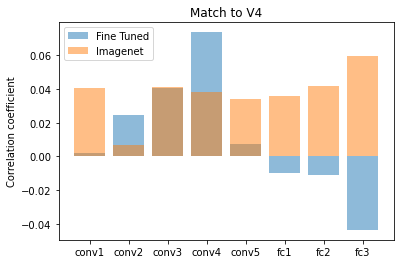

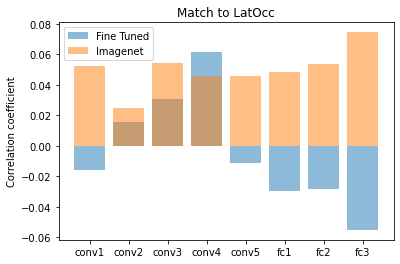

In [161]:
for j in range(roi_num):
    roi_name = dat['roi_names'][j+1]
    plt.bar(range(layer_num), r[j*2, :], alpha=0.5)
    plt.bar(range(layer_num), r[j*2+1, :], alpha=0.5)
    plt.legend(['Fine Tuned', 'Imagenet'])
    plt.ylabel('Correlation coefficient')
    plt.title(f'Match to {roi_name}')
    plt.xticks(range(layer_num), mid_outputs_ft.keys())
    plt.show()




## Perform PCA first

### Process BOLD Data
Run PCA on original BOLD data to reduce the noise. 

In [139]:
# seperate bold responses according to the roi
roi_responses_list_train = [] ; roi_responses_list_test = []
for roi_index in range(1,8):
    bold_index = dat['roi'] == roi_index
    roi_responses_list_train.append(
        np.array([ bold[bold_index] for bold in dat['responses']]))
    roi_responses_list_test.append(
        np.array([ bold[bold_index] for bold in dat['responses_test']]))


In [140]:
print(len(roi_responses_list_test))
roi_responses_list_test[0].shape

7


(120, 1294)

In [141]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import kendalltau
import pandas as pd


In [142]:
# write a pca function from scratch
def pca_bold(roi_bold_df):
    # Normalize the data
    x = StandardScaler().fit_transform(roi_bold_df)
    # compute the covar matrix
    roi_bold_df = roi_bold_df.T # Reduce the dimens of the voxels not labels
    covariance_matrix = np.cov(roi_bold_df)
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
    # calculate acculated variance
    variance_explained = [(i/eigen_values.sum())*100 for i in eigen_values]
    cumulative_variance_explained = np. cumsum(variance_explained)
    # selecte the components that explained 95% variances
    component_index = cumulative_variance_explained > 95
    main_component = list(component_index).index(True)
    # apply the projection
    projection_matrix = (eigen_vectors.T[:][:])[:main_component+1].T
    x_pca = roi_bold_df.T.dot(projection_matrix)
    
    return x_pca

In [143]:
pca_roi_responses_list_test = [pca_bold(df) for df in roi_responses_list_test]

In [144]:
dimens = []
roi_voxel_dic = dict(zip(dat["roi_names"], np.bincount(dat["roi"])))
for i in range(len(roi_responses_list_test)):
    dimens.append([roi_responses_list_test[i].shape[1], pca_roi_responses_list_test[i].shape[1]])

dimens_df = pd.DataFrame(dimens, columns = [ "Original Dimens", "Reduced Dimens"], 
             index=list(roi_voxel_dic.keys())[1:])
dimens_df

,Original Dimens,Reduced Dimens
V1,1294,83
V2,2083,87
V3,1790,90
V3A,484,75
V3B,314,72
V4,1535,95
LatOcc,928,87


### Calculate RDM

The bold responses in this dataset is already preprocessed and z-score transformed thus there is no need to calculation correlation coefficient. 
The RDM can be calculated using the following equation:
\begin{gather}
  \mathbf{M} = 1 - \frac{1}{N} \mathbf{ZZ}^T \\
\end{gather}

The element in $\mathbf{Z}$ is calculated by following equation:
\begin{equation}
  \mathbf{z}^{(s)} = \frac{\mathbf{r}^{(s)} - \mu^{(s)}}
  {\sigma^{(s)}}
\end{equation}
where $\mu^{(s)} = \frac{1}{N}\sum_{i=1}^N r_i^{(s)}$ and 
$\sigma^{(s)} = \sqrt{\frac{1}{N}\sum_{i=1}^N \left( r_i^{(s)} - \mu^{(s)} \right)^2}$.

In [145]:
import seaborn as sns
from matplotlib import pyplot as plt

In [146]:
from scipy.stats import zscore

def RDM(resp):
    """Compute the representational dissimilarity matrix (RDM)

    Args:
    resp (ndarray): S x N matrix with population responses to
      each stimulus in each row

    Returns:
    ndarray: S x S representational dissimilarity matrix
    """
    # z-score responses to each stimulus
    zresp = zscore(resp, axis=1)

    # Compute RDM
    RDM = 1 - (zresp @ zresp.T) / zresp.shape[1]

    return RDM

In [147]:
# correlation_method = "person"
RDMs_test = [np.around(np.real(RDM(df)),5) for df in pca_roi_responses_list_test]

In [148]:
# choose label: ori_labels_train; ori_labels_test

index = ori_labels_test

RDM_sorted_test = []
for rdm in RDMs_test:
    rdm = pd.DataFrame(rdm)
    rdm.columns = index
    rdm.index = index
    RDM_sorted_test.append(rdm)
    
rdmdf_v1, rdmdf_v2, rdmdf_v3, rdmdf_v3a, rdmdf_v3b, rdmdf_v4, rdmdf_latocc = RDM_sorted_test


V1


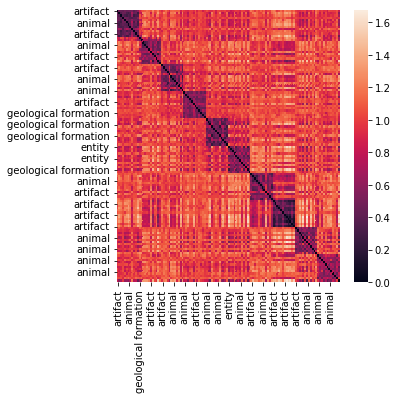

V2


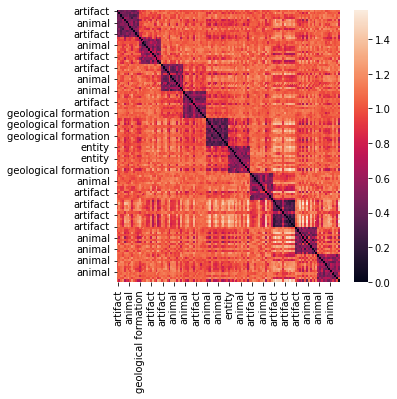

V3


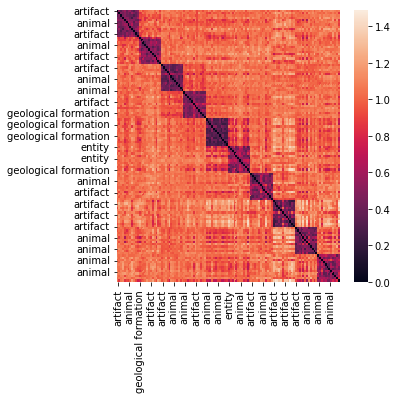

V3A


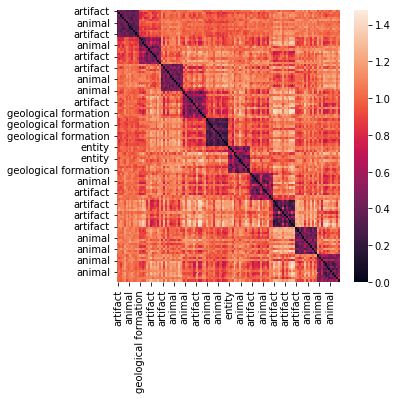

V3B


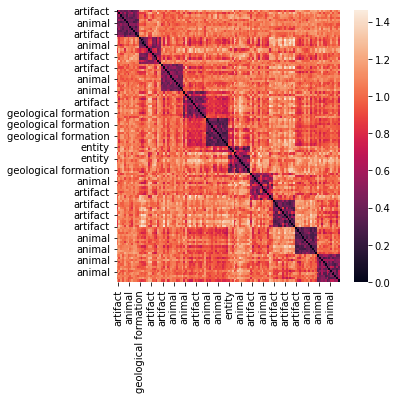

V4


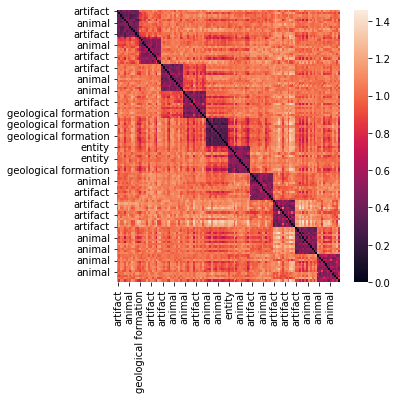

LatOcc


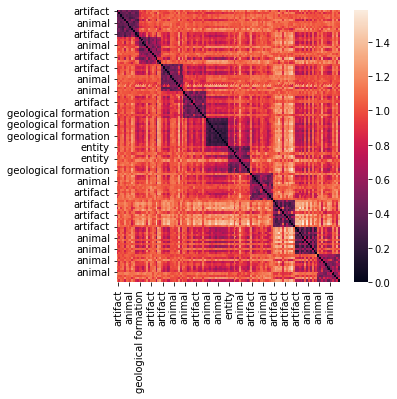

In [149]:
for index, rdm in enumerate(RDM_sorted_test):
    roi = list(roi_voxel_dic.keys())[index+1]
    print(roi)
    plt.figure(figsize=(5,5))
    #sns.heatmap(rdm, vmin = 0, vmax = 1, cmap="RdBu")
    sns.heatmap(rdm)
    # plt.savefig('./{}.png'.format(roi))
    plt.show()

### RSA

In [150]:
#@title rdm_correlation_spearman
from scipy.stats import spearmanr

# modified from neurora
def rdm_correlation_spearman(RDM1, RDM2, rescale=False):

    """
    Calculate the Spearman Correlation between two RDMs

    Parameters
    ----------
    RDM1 : array [ncons, ncons]
        The RDM 1.
        The shape of RDM1 must be [n_cons, n_cons].
        n_cons represent the number of conidtions.
    RDM2 : array [ncons, ncons].
        The RDM 2.
        The shape of RDM2 must be [n_cons, n_cons].
        n_cons represent the number of conidtions.
    rescale : bool True or False. Default is False.
        Rescale the values in RDM or not.
        Here, the maximum-minimum method is used to rescale the values except for the values on the diagonal.
-
    Returns
    -------
    corr : array [r, p].
        The Spearman Correlation result.
        The shape of corr is [2], including a r-value and a p-value.
    """

    if len(np.shape(RDM1)) != 2 or len(np.shape(RDM2)) != 2 or np.shape(RDM1)[0] != np.shape(RDM1)[1] or \
            np.shape(RDM2)[0] != np.shape(RDM2)[1]:

        print("\nThe shapes of two RDMs should be [ncons, ncons]!\n")

        return "Invalid input!"

    # get number of conditions
    cons = np.shape(RDM1)[0]

    # calculate the number of value above the diagonal in RDM
    n = int(cons*(cons-1)/2)

    if rescale == True:

        # flatten the RDM1
        vrdm = np.reshape(RDM1, [cons*cons])
        # array -> set -> list
        svrdm = set(vrdm)
        lvrdm = list(svrdm)
        lvrdm.sort()

        # get max & min
        maxvalue = lvrdm[-1]
        minvalue = lvrdm[1]

        # rescale
        if maxvalue != minvalue:

            for i in range(cons):
                for j in range(cons):

                    # not on the diagnal
                    if i != j:
                        RDM1[i, j] = float((RDM1[i, j] - minvalue) / (maxvalue - minvalue))

        # flatten the RDM2
        vrdm = np.reshape(RDM2, [cons * cons])
        # array -> set -> list
        svrdm = set(vrdm)
        lvrdm = list(svrdm)
        lvrdm.sort()

        # get max & min
        maxvalue = lvrdm[-1]
        minvalue = lvrdm[1]

        # rescale
        if maxvalue != minvalue:

            for i in range(cons):
                for j in range(cons):

                    # not on the diagnal
                    if i != j:
                        RDM2[i, j] = float((RDM2[i, j] - minvalue) / (maxvalue - minvalue))

    # initialize two vectors to store the values above the diagnal of two RDMs
    v1 = np.zeros([n], dtype=np.float64)
    v2 = np.zeros([n], dtype=np.float64)

    # assignment
    nn = 0
    for i in range(cons-1):
        for j in range(cons-1-i):
            v1[nn] = RDM1[i, i+j+1]
            v2[nn] = RDM2[i, i+j+1]
            nn = nn + 1

    # calculate the Spearman Correlation
    rp = np.array(spearmanr(v1, v2))


    return rp

In [156]:
# Loading V1 and LOC responses

RDMs_test = [np.around(np.real(RDM(df)),5) for df in pca_roi_responses_list_test]

# Observed dissimilarity  - Correlation
fMRI_dist_metric_ft = "euclidean"  # ['correlation', 'euclidean']
fMRI_dist_metric_im = "euclidean"  # ['correlation', 'euclidean']

Alexnet_ft_dist_metric = "euclidean"  # ['correlation', 'euclidean']
Alexnet_im_dist_metric = "euclidean"  # ['correlation', 'euclidean']

pdist_fts = [pdist(bold, fMRI_dist_metric_ft) for bold in RDMs_test]
pdist_ims = [pdist(bold, fMRI_dist_metric_im) for bold in RDMs_test]


# Comparing representation of V1 and LOC across different layers of Alexnet
layer_num = int(len(return_layers)); roi_num = int(len(ids))
r1 = np.zeros((roi_num*2, layer_num)) # 14 x 8 matrix
p1 = r.copy()
for i,l in enumerate(mid_outputs_ft.keys()):
    for j in range(roi_num):
        dnet_ft = pdist(torch.flatten(mid_outputs_ft[l], 1, -1).cpu().detach().numpy(),
                        Alexnet_ft_dist_metric)
        dnet_im = pdist(torch.flatten(mid_outputs_im[l], 1, -1).cpu().detach().numpy(),
                        Alexnet_im_dist_metric)
        r1[j*2, i], p1[j*2, i] = pearsonr(dnet_ft, pdist_fts[j])
        r1[j*2+1, i], p1[j*2+1, i] = pearsonr(dnet_im, pdist_ims[j])

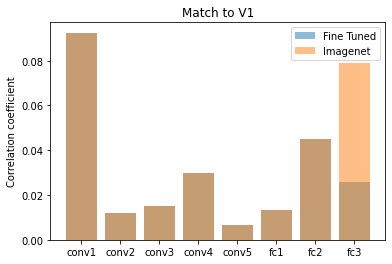

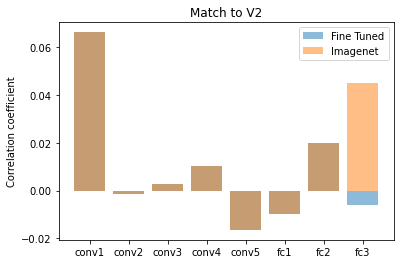

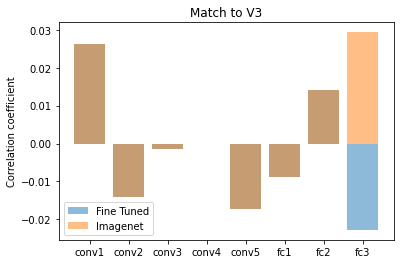

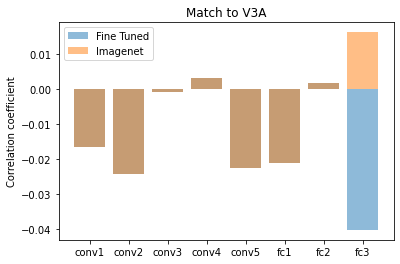

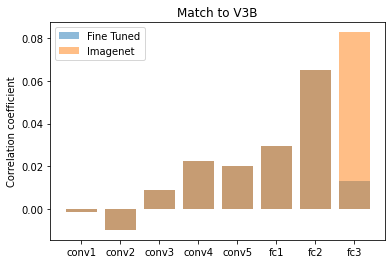

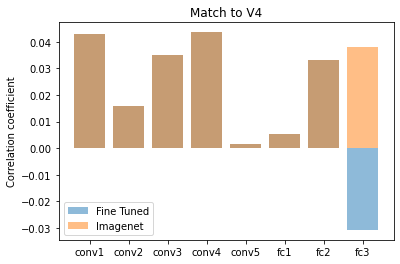

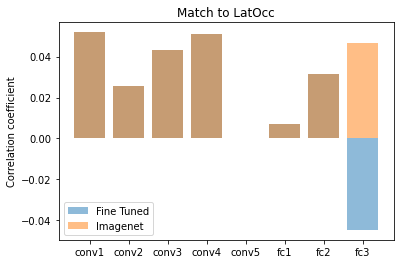

In [157]:
for j in range(roi_num):
    roi_name = dat['roi_names'][j+1]
    plt.bar(range(layer_num), r1[j*2, :], alpha=0.5)
    plt.bar(range(layer_num), r1[j*2+1, :], alpha=0.5)
    plt.legend(['Fine Tuned', 'Imagenet'])
    plt.ylabel('Correlation coefficient')
    plt.title(f'Match to {roi_name}')
    plt.xticks(range(layer_num), mid_outputs_ft.keys())
    plt.show()
